In [39]:
from sec_certs.dataset import FIPSDataset
from sec_certs.utils.extract import rules_get_subset, extract_key_paths
from sec_certs.cert_rules import fips_rules, PANDAS_KEYWORDS_CATEGORIES
from collections import Counter
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
import numpy as np
import tqdm
import matplotlib.ticker as mtick
import warnings
from pathlib import Path

plt.style.use("seaborn-whitegrid")
sns.set_palette("deep")
sns.set(rc={"figure.figsize":(8, 4)})
sns.set_context("notebook") # Set to "paper" for use in paper :)

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

In [2]:
dset = FIPSDataset.from_web_latest()
df = dset.to_pandas()

In [3]:
df.head()

,cert_id,name,status,standard,type,level,embodiment,date_validation,date_sunset,algorithms,...,related_cves,web_directly_referenced_by,web_indirectly_referenced_by,web_directly_referencing,web_indirectly_referencing,st_directly_referenced_by,st_indirectly_referenced_by,st_directly_referencing,st_indirectly_referencing,year_from
dgst,,,,,,,,,,,,,,,,,,,,,
fc95ce176603e9e1,339,Anonymous Key Technology (AKT) C++ Module (CPP...,Historical,FIPS140-2,Software,1.0,Multi Chip Standalone,2003-07-31,NaT,"{AES algorithm #3194 created by None, None alg...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003
158f3b1a355d5f64,2798,Red Hat Enterprise Linux Kernel Crypto API Cry...,Historical,FIPS140-2,Software Hybrid,1.0,Multi Chip Standalone,2016-11-23,NaT,"{None algorithm #3591 created by None, None al...",...,"{CVE-2007-6285, CVE-2007-2030, CVE-2011-3585, ...",NaN,NaN,"{2721, 2711}","{2441, 2721, 2711}",NaN,NaN,"{2721, 2711}","{2441, 2721, 2711}",2016
47e03bf0b0b8b738,2943,TCT Crypto Engine Core,Historical,FIPS140-2,Hardware,2.0,Single Chip,2017-06-23,NaT,"{None algorithm 256 created by None, None algo...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,{2614},{2614},2017
f6920d2ecbf72069,1385,Red Hat Enterprise Linux 5 OpenSSH Client Cryp...,Historical,FIPS140-2,Software,1.0,Multi Chip Standalone,2010-08-12,NaT,"{None algorithm 31 created by None, None algor...",...,"{CVE-2011-1593, CVE-2000-0701, CVE-2014-3566, ...",NaN,NaN,{1320},{1320},NaN,NaN,{1320},{1320},2010
2cfc8ccbd7c0b176,294,nCipher 800 PCI and nCipher 1600 PCI,Historical,FIPS140-2,Hardware,3.0,Multi Chip Embedded,2003-03-07,NaT,"{Triple-DES algorithm #109 created by None, AE...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2003


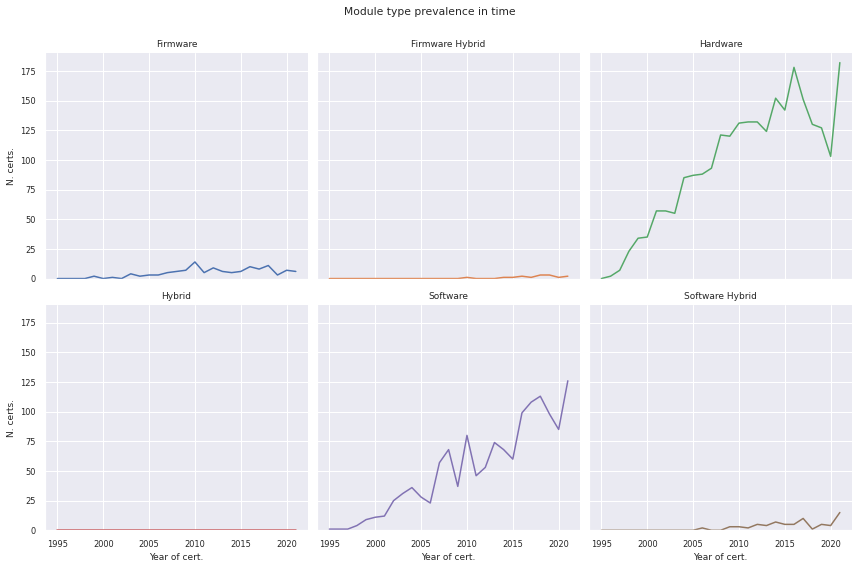

In [40]:
categories = df.loc[df.year_from < 2022].groupby(["year_from", "type"], as_index=False).size().copy()

with sns.plotting_context("notebook", font_scale=0.75):
    g = sns.FacetGrid(categories, col="type", hue="type", col_wrap=3, height=4, ylim=(0,190))
    g.map(sns.lineplot, "year_from", "size")
    g.set(xlabel="Year of cert.", ylabel="N. certs.")
    g.set_titles("{col_name}")
    g.fig.subplots_adjust(top=0.90)
    g.fig.suptitle('Module type prevalence in time')
    plt.show()

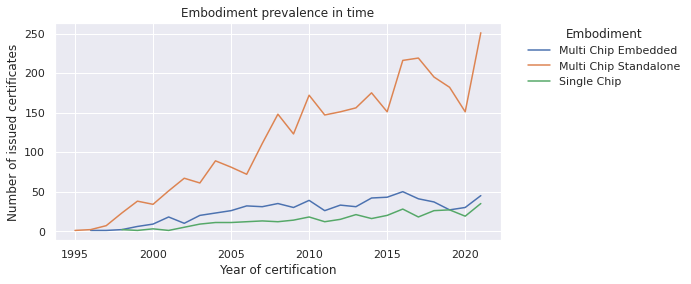

In [41]:
embodiments = df.loc[(df.embodiment.notnull()) & (df.year_from < 2022)].groupby(["year_from", "embodiment"], as_index=False, observed=True).size()

line = sns.lineplot(data=embodiments, x="year_from", y="size", hue="embodiment")
line.set(xlabel="Year of certification", ylabel="Number of issued certificates", title="Embodiment prevalence in time")
line.legend(title="Embodiment", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

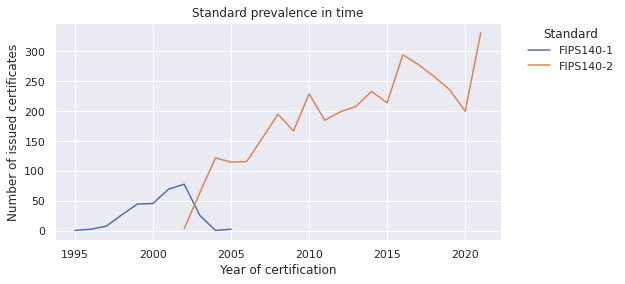

In [42]:
standards = df.loc[(df.standard.notnull()) & (df.year_from < 2022)].groupby(["year_from", "standard"], as_index=False, observed=True).size()

line = sns.lineplot(data=standards, x="year_from", y="size", hue="standard")
line.set(xlabel="Year of certification", ylabel="Number of issued certificates", title="Standard prevalence in time")
line.legend(title="Standard", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

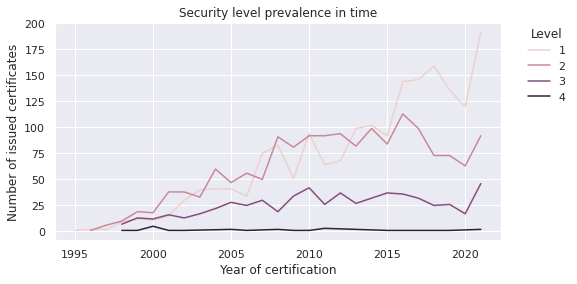

In [43]:
sec_levels = df.loc[(df.level.notnull()) & (df.year_from < 2022)].groupby(["year_from", "level"], as_index=False).size()
sec_levels.level = sec_levels.level.astype(int)

line = sns.lineplot(data=sec_levels, x="year_from", y="size", hue="level")
line.set(xlabel="Year of certification", ylabel="Number of issued certificates", title="Security level prevalence in time")
line.legend(title="Level", bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

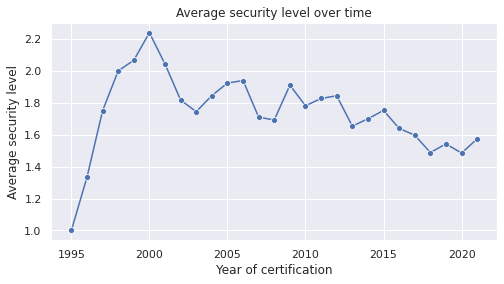

In [44]:
avg_levels = df.loc[(df.year_from < 2022) & (df.level.notnull())].copy().groupby(["year_from"]).agg({'year_from':'size', 'level':'mean'}).rename(columns={"year_from": "n_certs"}).reset_index()
avg_levels.year_from = avg_levels.year_from.astype("float")
avg_levels.level = avg_levels.level.astype("float")

ymin = math.floor(avg_levels.level.min())
ymax = math.ceil(avg_levels.level.max())

line = sns.lineplot(data=avg_levels, x="year_from", y="level", marker='o')
line.set(xlabel="Year of certification", ylabel="Average security level", title="Average security level over time");

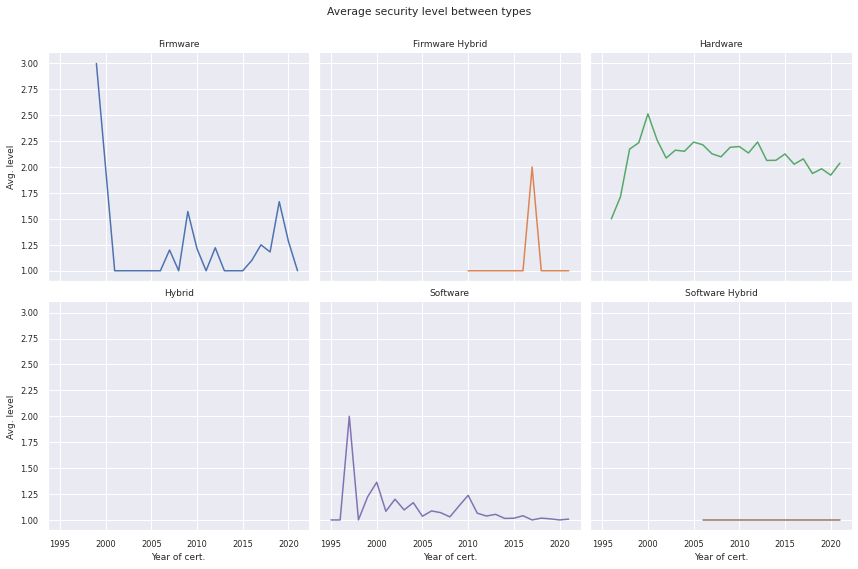

In [45]:
avg_levels = df.loc[(df.year_from < 2022) & (df.level.notnull())].copy().groupby(["year_from", "type"]).agg({'year_from':'size', 'level':'mean'}).rename(columns={"year_from": "n_certs"}).reset_index()
avg_levels.year_from = avg_levels.year_from.astype("float")
avg_levels.level = avg_levels.level.astype("float")

with sns.plotting_context("notebook", font_scale=0.75):
    g = sns.FacetGrid(avg_levels, col="type", hue="type", col_wrap=3, height=4)
    g.map(sns.lineplot, "year_from", "level")
    g.set(xlabel="Year of cert.", ylabel="Avg. level")
    g.set_titles("{col_name}")
    g.fig.subplots_adjust(top=0.90)
    g.fig.suptitle('Average security level between types')
    plt.show()


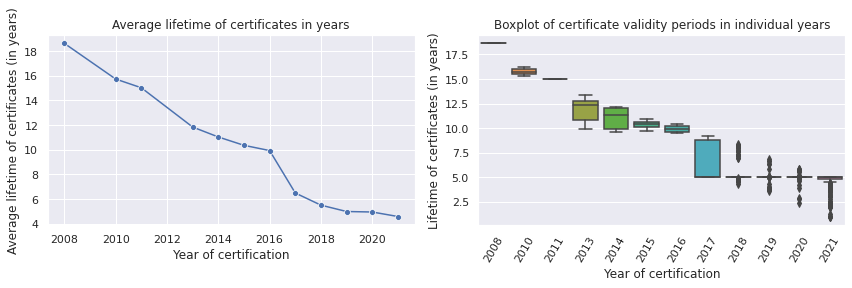

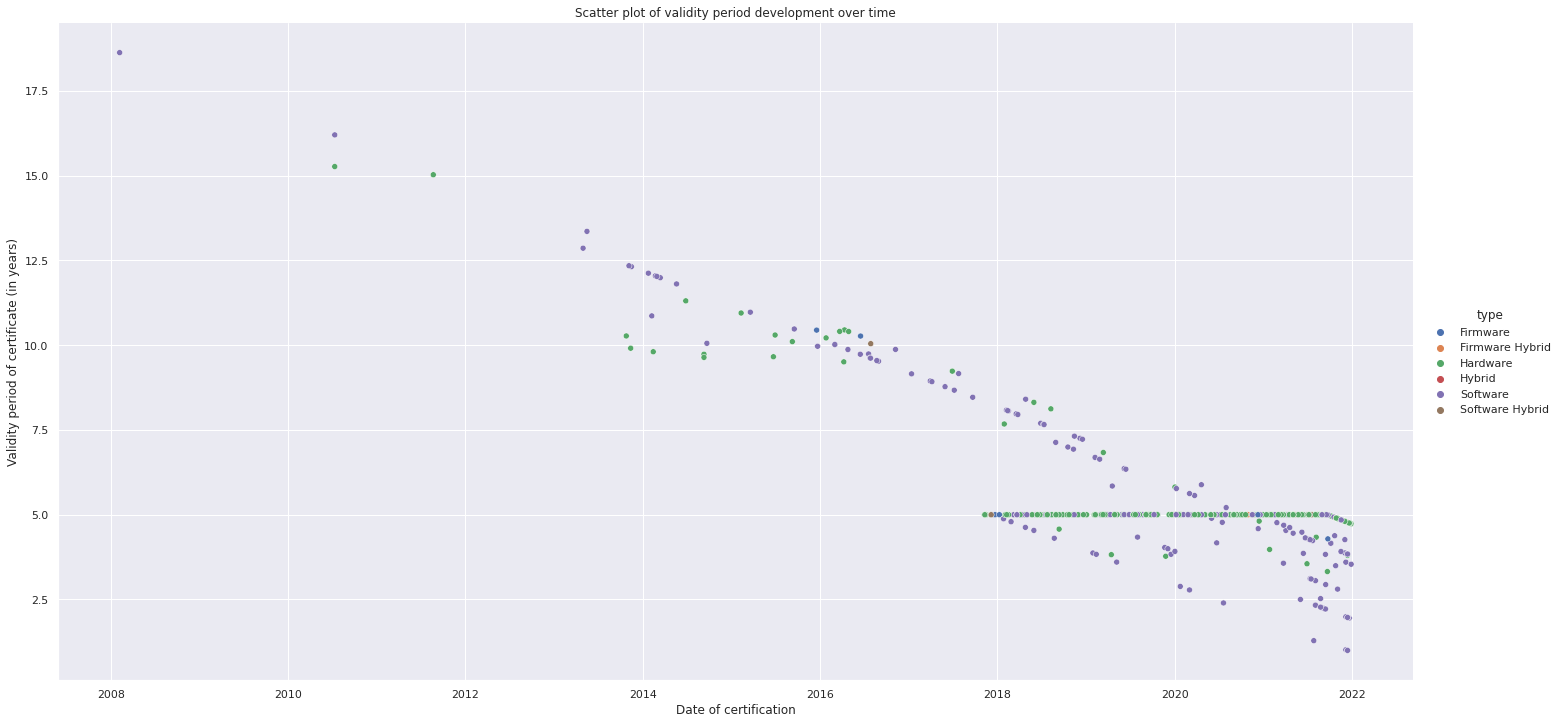

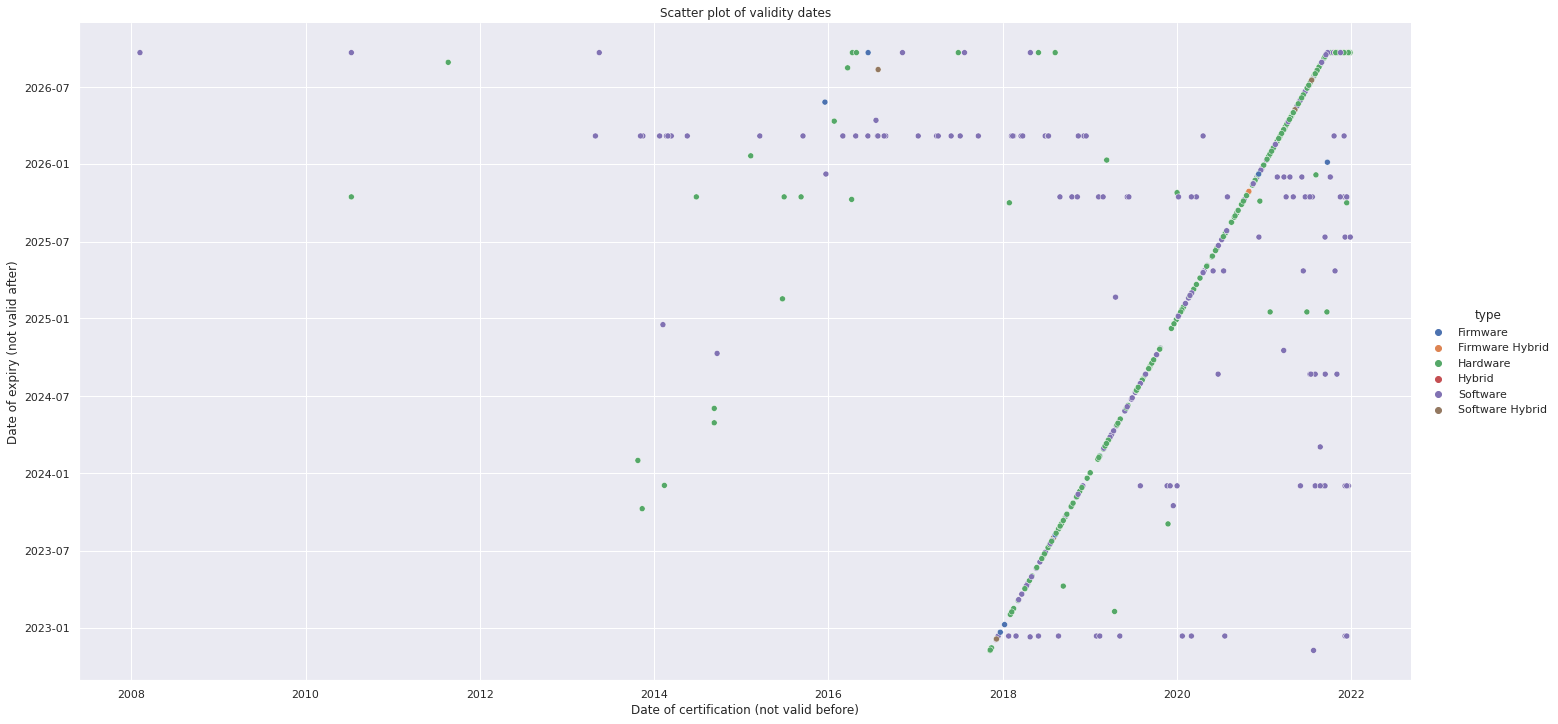

In [46]:
df["validity_period"] = (df.date_sunset - df.date_validation).dt.days / 365

df_validity = df.loc[(df.validity_period.notnull()) & (df.year_from < 2022)]
validity_period = df_validity.groupby("year_from").agg({'year_from':'size', 'validity_period':'mean'}).rename(columns={"year_from": "n_certs"}).reset_index()

figure, axes = plt.subplots(1, 2)
figure.set_size_inches(12, 4)
figure.set_tight_layout(True)

line = sns.lineplot(data=validity_period, x="year_from", y="validity_period", marker="o", ax=axes[0])
line.set(xlabel="Year of certification", ylabel="Average lifetime of certificates (in years)", title="Average lifetime of certificates in years")

box = sns.boxplot(data=df_validity, x="year_from", y="validity_period", ax=axes[1])
box.set(xlabel="Year of certification", ylabel="Lifetime of certificates (in years)", title="Boxplot of certificate validity periods in individual years")
box.tick_params(axis='x', rotation=60)

strips = sns.relplot(kind="scatter", data=df_validity, x="date_validation", y="validity_period", height=10, aspect=2/1, hue="type")
strips.set(title="Scatter plot of validity period development over time", xlabel="Date of certification", ylabel="Validity period of certificate (in years)")

scatter = sns.relplot(kind="scatter", data=df_validity, x="date_validation", y="date_sunset", height=10, aspect=2/1, hue="type")
scatter.set(title="Scatter plot of validity dates", xlabel="Date of certification (not valid before)", ylabel="Date of expiry (not valid after)");

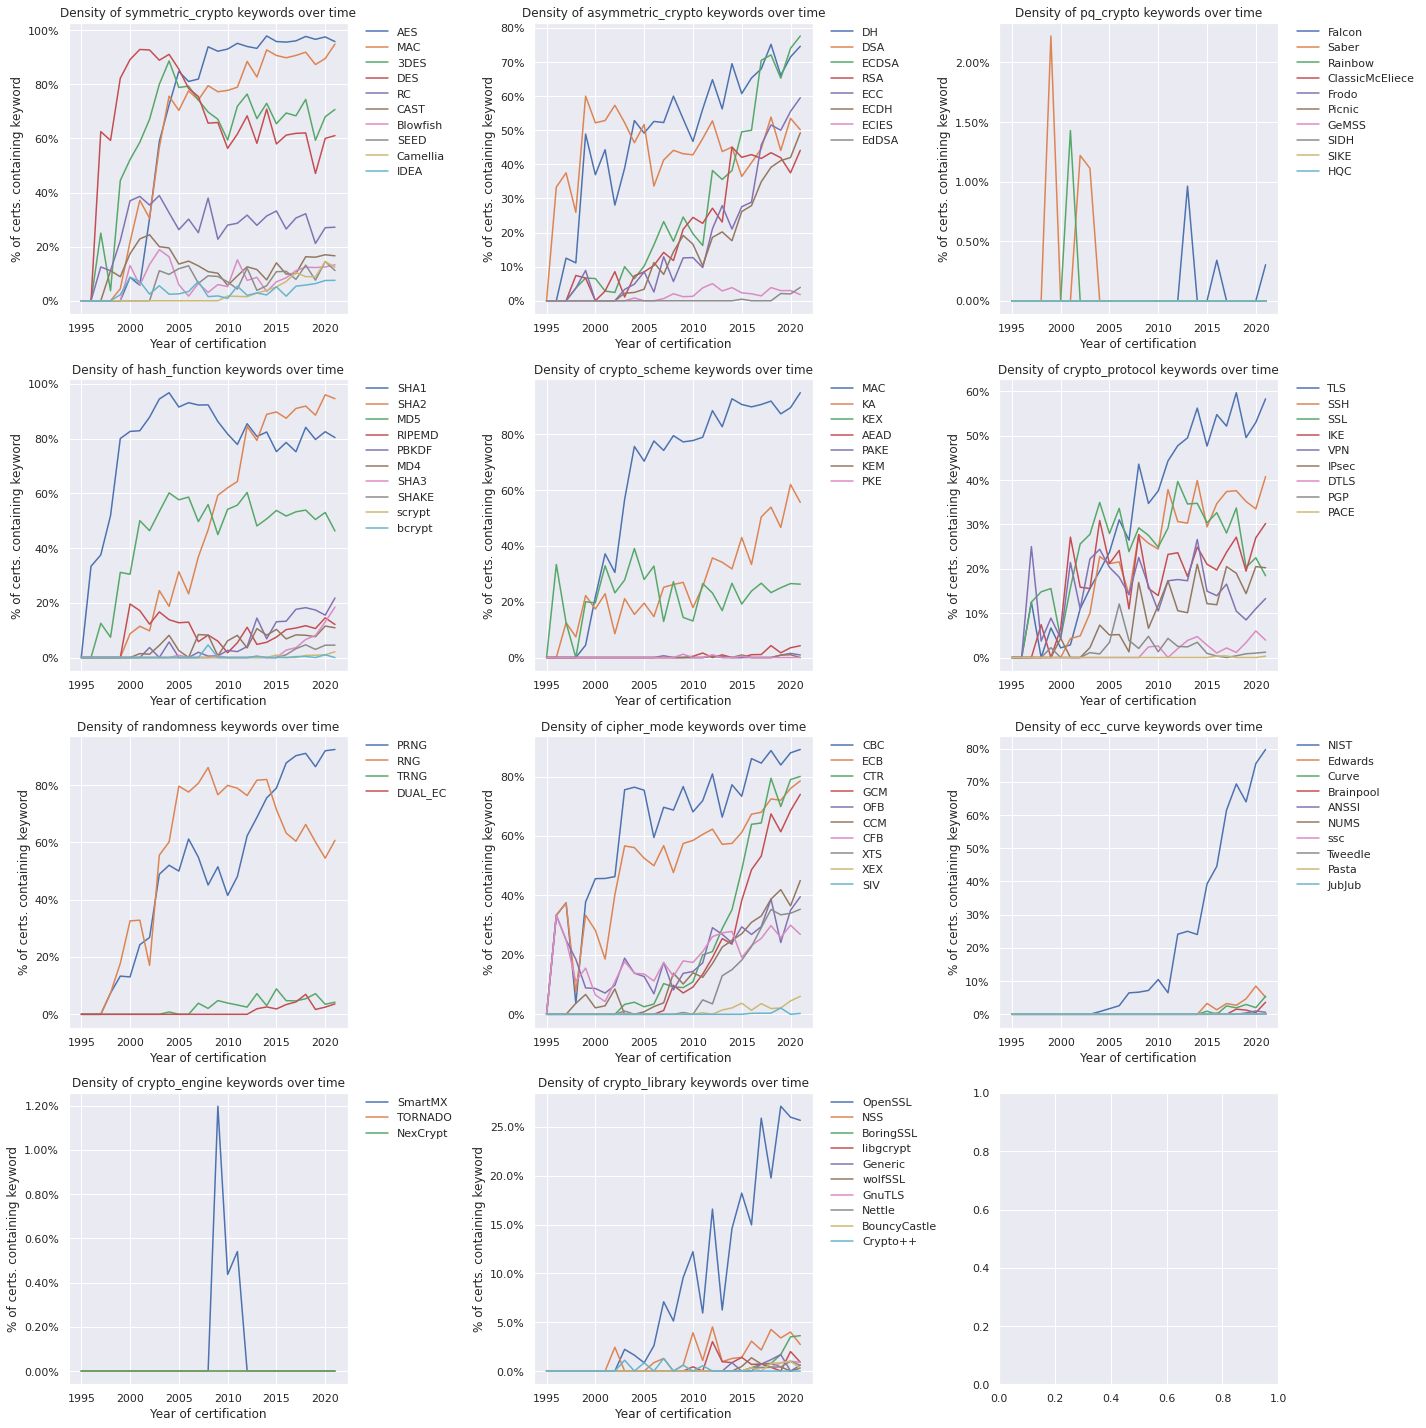

In [47]:
# TODO: Resolve duplicity in crypto_scheme mac
st_keywords_df = dset.get_st_keywords_df().drop(columns=["crypto_scheme.MAC"])
st_keywords_df = st_keywords_df.rename(columns={x: x.split(".")[-1] for x in st_keywords_df.columns}).fillna(0).applymap(lambda x: x > 0)

df_keywords = df.loc[:, ["type", "level", "date_validation", "date_sunset", "year_from"]].copy()
df_keywords = df_keywords.join(st_keywords_df).loc[df_keywords.year_from < 2022].copy()

figure, axes = plt.subplots(4, 3)
figure.set_size_inches(20, 20)
figure.set_tight_layout(True)
row = 0
col = 0

for examined_category in PANDAS_KEYWORDS_CATEGORIES:
    rules_subset = rules_get_subset(examined_category)
    keywords = [x.split(".")[-1] for x in extract_key_paths(rules_subset, examined_category)]
    top_n_keywords = df_keywords.loc[:, keywords].sum().sort_values(ascending=False).head(10).index
    
    # Count number of non-zero rows for each year, weight by number of certificates issued in the given year. 
    crypto = df_keywords.groupby("year_from")[top_n_keywords].sum()
    crypto["n_certs"] = df_keywords.groupby("year_from").size()
    crypto.iloc[:,:-1] = crypto.iloc[:,:-1].div(crypto.n_certs, axis=0) * 100
    crypto = crypto.drop(columns=["n_certs"]).reset_index().melt(id_vars="year_from", var_name="keyword", value_name="percentage")  # Bring to tidy form

    line = sns.lineplot(data=crypto, x="year_from", y="percentage", hue="keyword", ax=axes[row][col])
    line.set(title=f"Density of {examined_category} keywords over time", xlabel="Year of certification", ylabel="% of certs. containing keyword")
    line.yaxis.set_major_formatter(mtick.PercentFormatter())
    line.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

    if col == 2:
        col = 0
        row += 1
    else:
        col += 1

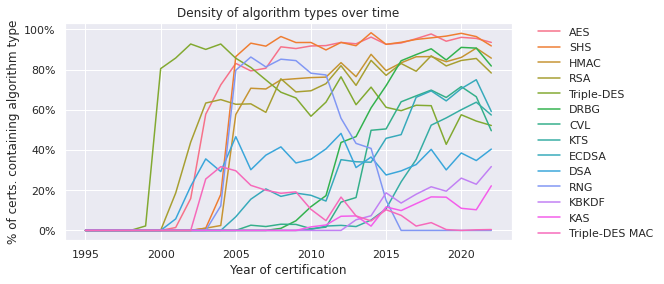

In [49]:
def algo_present(algorithms, algo):
    for a in algorithms:
        if a.algorithm_type == algo:
            return True
    return False

algo_types = Counter()
for algos in df.algorithms:
    for algo in algos:
        if algo.algorithm_type:
            algo_types[algo.algorithm_type] +=1
#print(algo_types)
df_algos = df.loc[:, ["type", "level", "date_validation", "date_sunset", "year_from", "algorithms"]].copy()
for algo, count in algo_types.most_common(14):
    df_algos[algo] = df_algos.algorithms.apply(algo_present, args=(algo,))
    
crypto = df_algos.groupby("year_from").sum()
crypto["n_certs"] = df_algos.groupby("year_from").size()
crypto.iloc[:,:-1] = crypto.iloc[:,:-1].div(crypto.n_certs, axis=0) * 100
crypto = crypto.drop(columns=["level","n_certs"]).reset_index().melt(id_vars="year_from", var_name="keyword", value_name="percentage")  # Bring to tidy form

line = sns.lineplot(data=crypto, x="year_from", y="percentage", hue="keyword")
line.set(title=f"Density of algorithm types over time", xlabel="Year of certification", ylabel="% of certs. containing algorithm type")
line.yaxis.set_major_formatter(mtick.PercentFormatter())
line.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);